In [43]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, roc_curve
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
# pd.set_option('display.float_format', '{:.4f}'.format)

from sentence_transformers import SentenceTransformer, util

import json
import glob

import pickle

from sklearn.decomposition import PCA

In [2]:
# pd.set_option('display.max_colwidth', None)
# np.set_printoptions(threshold=np.inf, linewidth=200, suppress=True)

In [3]:
all_data = []
for file in glob.glob("../data/processed/*.json"):
    print(file)
    with open(file, "r") as f:
        all_data.extend(json.load(f))

df = pd.DataFrame(all_data)
df = df.dropna(thresh=8)
df = df.reset_index(drop=True)

../data/processed\channels0_99.json
../data/processed\channels100_.json
../data/processed\channels3425_.json
../data/processed\channels6727_.json
../data/processed\channelsa10034_.json
../data/processed\channelsa13313_.json
../data/processed\channels_missing.json


In [4]:
df["created_date"] = pd.to_datetime(df["created_date"], format="ISO8601")

In [5]:
df.head()

,channel_id,channel_name,description,country,defaultLanguage,created_date,category,aggregated_tags,most_common_video_genre,all_video_genres,avg_duration_seconds,avg_seconds_between_uploads,recent_video_titles
0,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,BLACKPINK Official YouTube Channel\n블랙핑크 공식 유튜...,KR,None,2016-06-29 03:15:23+00:00,"[Electronic music, Pop music, Music of Asia, M...","[JISOO, YG, JENNIE You & Me, LISA, JENNIE 유앤미,...",Music,[Music],211.6,1017992.89,[BLACKPINK - WORLD TOUR [DEADLINE] IN HONG KON...
1,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,Welcome to the official YouTube channel of HYB...,KR,None,2008-06-04 08:23:22+00:00,"[Pop music, Music, Music of Asia]","[하이브, 하이브레이블즈, HYBE LABELS, HYBE]",Music,[Music],89.6,131588.11,[SANTOS BRAVOS “KAWASAKI (&TEAM Remix)” Lyric ...
2,UCF1JIbMUs6uqoZEY1Haw0GQ,Shemaroo,"Welcome to ShemarooEnt, one of the finest dest...",IN,None,2007-09-01 11:44:51+00:00,"[Film, Entertainment]","[salman khan movies, ramcharana moves, Mega Po...",Entertainment,[Entertainment],5336.1,45200.00,[Mega Power Star Ram Charan 👑 | Zanjeer (4K Ac...
3,UCYiGq8XF7YQD00x7wAd62Zg,JuegaGerman,Lento pero seguro.,CL,None,2013-05-19 00:09:13+00:00,"[Action game, Video game culture, Action-adven...","[revenia, juega german, juego de miedo, click ...",Gaming,[Gaming],2046.9,280466.00,"[Fotos Tomadas En El Momento PERFECTO 📸, Traba..."
4,UC4NALVCmcmL5ntpV0thoH6w,LooLoo Kids - Nursery Rhymes and Children's Songs,LooLoo Kids💖 is an educational YouTube channel...,US,en,2014-08-05 20:15:33+00:00,"[Entertainment, Music, Film]","[kids videos, children songs, farm song nurser...",Music,[Music],148.5,181623.89,[Old Macdonald Had a Farm Song + Johny Johny Y...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15743 entries, 0 to 15742
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   channel_id                   15743 non-null  object             
 1   channel_name                 15743 non-null  object             
 2   description                  15743 non-null  object             
 3   country                      13977 non-null  object             
 4   defaultLanguage              1725 non-null   object             
 5   created_date                 15743 non-null  datetime64[ns, UTC]
 6   category                     15743 non-null  object             
 7   aggregated_tags              15743 non-null  object             
 8   most_common_video_genre      15743 non-null  object             
 9   all_video_genres             15743 non-null  object             
 10  avg_duration_seconds         15743 non-null  f

In [7]:
time_cols = ["created_date"]
num_cols = ["avg_duration_seconds", "avg_seconds_between_uploads"]
basic_cat_cols = ["country", "most_common_video_genre"]
multi_cat_cols = ["category", "all_video_genres"]
text_cols = ["description", "aggregated_tags", "recent_video_titles"]
drop_cols = ["channel_id", "channel_name", "defaultLanguage"]
set(time_cols + num_cols + basic_cat_cols + multi_cat_cols + text_cols + drop_cols) == set(df.columns)

True

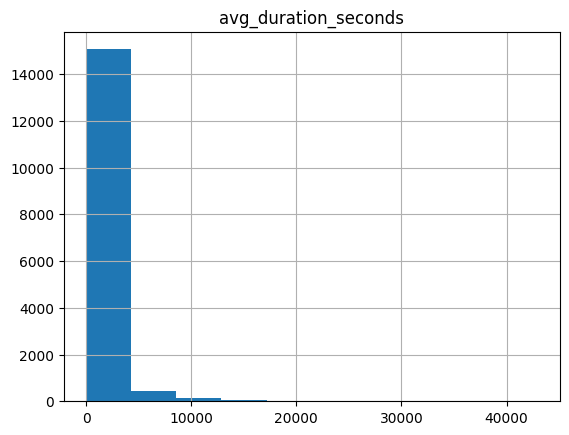

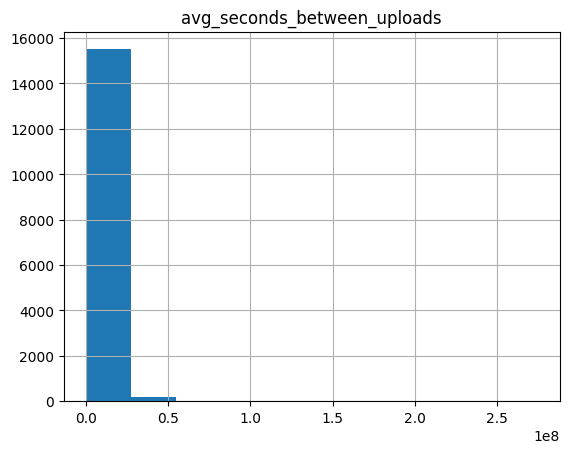

In [8]:
for col in num_cols:
    plt.figure()
    df[col].hist()
    plt.title(col)
    plt.show()

lets investigate the outliers that are stretching the x axis

In [9]:
20000/3600

5.555555555555555

In [10]:
df[df["avg_duration_seconds"] > 20000][["channel_name", "avg_duration_seconds"]].sort_values("avg_duration_seconds", ascending=False)

,channel_name,avg_duration_seconds
10770,Relaxing Nature In 4K,42898.5
1217,BogMonsterZ,39552.2
7143,Zombies Gameplay,39463.3
2630,Ensiklopedia Al Fatih,38830.7
12071,LimeTube_Brasil,35899.1
4521,Scary Teacher 3D Gaming,34701.0
10046,Lets Test Laurence,34311.8
6394,Lullaby Baby,32258.3
3553,Moxie2D,31271.4
12673,Monkey Daily,29487.6


i mean this data is accurate, doesnt make much sense to eliminate these  
perhaps in the future different models for different types of channels?

In [11]:
df[df["avg_seconds_between_uploads"] > 0.5e8][["channel_name", "avg_seconds_between_uploads"]].sort_values("avg_seconds_between_uploads", ascending=False)

,channel_name,avg_seconds_between_uploads
14097,Aroma Split,2.745860e+08
4134,Amazon Discount Fairy,1.881258e+08
4996,GrumpyDog,1.730570e+08
11725,Fainted,1.429783e+08
12216,WrzzerPlays,1.306925e+08
5532,MemerMan,1.144614e+08
1424,xuxaVEVO,1.054944e+08
3630,Jefflau,1.027152e+08
3260,Wrestle Highlights,8.752221e+07
6995,officialTUNA,8.209671e+07


In [12]:
274585951.0000 / 86400

3178.078136574074

recall 0 values in avg_duration_seconds were errors...  
also None values for avg video gap investigate?  
basically yt channels with little/no uploads, impersonation channels...  

honestly i think i should just build model and revise these data problems in iteration 2

preprocessing pipeline next

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15743 entries, 0 to 15742
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   channel_id                   15743 non-null  object             
 1   channel_name                 15743 non-null  object             
 2   description                  15743 non-null  object             
 3   country                      13977 non-null  object             
 4   defaultLanguage              1725 non-null   object             
 5   created_date                 15743 non-null  datetime64[ns, UTC]
 6   category                     15743 non-null  object             
 7   aggregated_tags              15743 non-null  object             
 8   most_common_video_genre      15743 non-null  object             
 9   all_video_genres             15743 non-null  object             
 10  avg_duration_seconds         15743 non-null  f

In [14]:
df[df["avg_duration_seconds"] == 0]

,channel_id,channel_name,description,country,defaultLanguage,created_date,category,aggregated_tags,most_common_video_genre,all_video_genres,avg_duration_seconds,avg_seconds_between_uploads,recent_video_titles
166,UCANLZYMidaCbLQFWXBC95Jg,TaylorSwiftVEVO,"I'm the problem, it's me.",US,en,2009-05-12 05:29:33+00:00,[Music],[],Music,[Music],0.0,NaN,[TaylorSwiftVEVO Live Stream]
1459,UCG6XmGtwd0geNvV7CZKEACQ,KendjiGiracVEVO,"Kendji Girac sur Vevo – Clips Officiels, Lyric...",None,en,2014-06-17 15:51:52+00:00,[Music],[],Music,[Music],0.0,NaN,[KendjiGiracVEVO Live Stream]
1570,UCW2afgCqiPQ6Y6EAiJAcH8A,Disar5,Canal de entretenimiento,None,None,2010-03-21 18:41:49+00:00,[],[],Entertainment,[Entertainment],0.0,NaN,[Emisión en directo de Disar5]
1773,UCcMTZY1rFXO3Rj44D5VMyiw,Machinima,Machinima is the most notorious purveyor and c...,US,None,2006-01-17 01:37:54+00:00,[],"[not fortnite, not sponsored, help, Game Of Th...",Gaming,[Gaming],0.0,NaN,[NEW PVP META? MASSIVE UPDATE! // 959+ Player ...
2129,UCJzfwEcHC2HZ6VvmEl-ulkA,BTWJUSTIN,SINCE 2015. 5. 26. \nreact to popular videos s...,US,None,2014-10-26 23:55:09+00:00,[],[],People & Blogs,[People & Blogs],0.0,NaN,[BeasTWO님의 실시간 스트리밍]
2544,UCYlMSCISQkNhajMPIVqN8KA,Rob Plevin,We provide ready-made classroom management sol...,None,None,2010-01-07 11:30:41+00:00,[],[],Education,[Education],0.0,NaN,[Rob Plevin (Behaviour Needs) Live Stream]
3037,UCruVT1tJ3S8r3tHSp6P4nCA,The House Protocol,Welcome to The House Protocol.\n\n​Bridging th...,US,None,2014-03-13 17:49:55+00:00,[],[],Entertainment,[Entertainment],0.0,NaN,[Instant Wonders Live Stream]
3524,UCBP4B896svWOcWdRp8UjH2Q,Jace Norman,Jace Norman / Xander Norman // filmmakers / en...,US,None,2012-01-02 04:40:17+00:00,[],[],Entertainment,[Entertainment],0.0,NaN,[Jace Norman Live Stream]
3641,UCi0ZJJC7ElVN0xl9GJ4V9aQ,Rebecca Maddie Challenges,,US,None,2020-05-02 21:08:04.510685+00:00,[],[],People & Blogs,[People & Blogs],0.0,NaN,[Rebecca Maddie Challenges Live Stream]
4634,UCafYgzpyw7aIUYOLjjADu7w,News18 UP Uttarakhand,SUBSCRIBE to get the Latest News & Updates - h...,IN,None,2010-06-16 10:11:50+00:00,"[Politics, Society]","[iran news today, america iran war live, ameri...",News & Politics,[News & Politics],0.0,207.56,[Iran America War Live: ट्रंप के निशाने पर सुप...


In [15]:
df[df["recent_video_titles"].apply(lambda x: len(x) <= 1)]

,channel_id,channel_name,description,country,defaultLanguage,created_date,category,aggregated_tags,most_common_video_genre,all_video_genres,avg_duration_seconds,avg_seconds_between_uploads,recent_video_titles
166,UCANLZYMidaCbLQFWXBC95Jg,TaylorSwiftVEVO,"I'm the problem, it's me.",US,en,2009-05-12 05:29:33+00:00,[Music],[],Music,[Music],0.0,NaN,[TaylorSwiftVEVO Live Stream]
1459,UCG6XmGtwd0geNvV7CZKEACQ,KendjiGiracVEVO,"Kendji Girac sur Vevo – Clips Officiels, Lyric...",None,en,2014-06-17 15:51:52+00:00,[Music],[],Music,[Music],0.0,NaN,[KendjiGiracVEVO Live Stream]
1570,UCW2afgCqiPQ6Y6EAiJAcH8A,Disar5,Canal de entretenimiento,None,None,2010-03-21 18:41:49+00:00,[],[],Entertainment,[Entertainment],0.0,NaN,[Emisión en directo de Disar5]
1773,UCcMTZY1rFXO3Rj44D5VMyiw,Machinima,Machinima is the most notorious purveyor and c...,US,None,2006-01-17 01:37:54+00:00,[],"[not fortnite, not sponsored, help, Game Of Th...",Gaming,[Gaming],0.0,NaN,[NEW PVP META? MASSIVE UPDATE! // 959+ Player ...
1836,UCFfO_LunUG-5ZXCcrg2Hc3g,Funny Kids,We love our funny kids. The earth is more beau...,None,None,2015-08-01 11:06:44+00:00,[],[Am A Gummy Bear (The Gummy Bear Song) (Musica...,People & Blogs,[People & Blogs],151.0,NaN,[★ Just Dance Kids 2 - I'm a Gummy Bear (The G...
2129,UCJzfwEcHC2HZ6VvmEl-ulkA,BTWJUSTIN,SINCE 2015. 5. 26. \nreact to popular videos s...,US,None,2014-10-26 23:55:09+00:00,[],[],People & Blogs,[People & Blogs],0.0,NaN,[BeasTWO님의 실시간 스트리밍]
2544,UCYlMSCISQkNhajMPIVqN8KA,Rob Plevin,We provide ready-made classroom management sol...,None,None,2010-01-07 11:30:41+00:00,[],[],Education,[Education],0.0,NaN,[Rob Plevin (Behaviour Needs) Live Stream]
2838,UCEESFTxvnLsO_qjbFasFfwg,Desi Health Tips,,PK,None,2014-11-18 04:22:53+00:00,[],[],People & Blogs,[People & Blogs],163.0,NaN,[I Am Back After 730 Days !!!]
2850,UCU7nMPggX3gFyIIYFax6kkw,Voicelove Balanced Nutrition,"Helping you lose fat, feel better, and keep it...",MK,None,2009-08-13 14:11:05+00:00,[],"[One, Will, Yeah, Sound, Game, Movie, Hangover...",Film & Animation,[Film & Animation],383.0,NaN,[Project X - Yeah Yeah Yeahs - Heads Will Ro...
3037,UCruVT1tJ3S8r3tHSp6P4nCA,The House Protocol,Welcome to The House Protocol.\n\n​Bridging th...,US,None,2014-03-13 17:49:55+00:00,[],[],Entertainment,[Entertainment],0.0,NaN,[Instant Wonders Live Stream]


fair amount of channels with not much videos...i dont really want these

In [16]:
df[df["category"].apply(lambda x: len(x) == 0)]

,channel_id,channel_name,description,country,defaultLanguage,created_date,category,aggregated_tags,most_common_video_genre,all_video_genres,avg_duration_seconds,avg_seconds_between_uploads,recent_video_titles
508,UC-ASDT9n-sUPwA7uUPN0OoQ,Calon Sarjana,Selamat datang di channel Calon Sarjana Kedua ...,ID,None,2017-08-09 07:24:38+00:00,[],"[Calon Sarjana, Aneh tapi nyata, Misteri, vira...",Entertainment,[Entertainment],659.1,48000.22,[OTAKMU BAKAL MELEDAK! 🧠⚠️ Inilah Teknik Out o...
1195,UC7QoBWa_qo29Heg4LYYsm-g,TomoNews Indonesia,Selamat datang di TomoNews Indonesia!\n\nKami ...,ID,None,2015-10-23 07:13:30+00:00,[],"[Next Animation Studio, TomoNews, News Animati...",News & Politics,[News & Politics],43.0,21599.44,"[Mengharukan, Wanita Kenakan Baju Pengantin di..."
1335,UCOaD4JxNYk29LHbHTOx3SQA,Did You Know ?,"Welcome to the official YouTube channel, Did Y...",US,en,2016-02-15 19:52:17+00:00,[],"[drone footage, Sees, Screaming, stories, weir...",Education,[Education],591.9,28800.00,[Girl Finds Strange Coin In The Forest - Next ...
1570,UCW2afgCqiPQ6Y6EAiJAcH8A,Disar5,Canal de entretenimiento,None,None,2010-03-21 18:41:49+00:00,[],[],Entertainment,[Entertainment],0.0,NaN,[Emisión en directo de Disar5]
1773,UCcMTZY1rFXO3Rj44D5VMyiw,Machinima,Machinima is the most notorious purveyor and c...,US,None,2006-01-17 01:37:54+00:00,[],"[not fortnite, not sponsored, help, Game Of Th...",Gaming,[Gaming],0.0,NaN,[NEW PVP META? MASSIVE UPDATE! // 959+ Player ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15154,UCAPByrKU5-R1emswVlyH_-g,Motiversity,Motiversity is one of the largest motivational...,CA,en,2015-06-23 03:00:10+00:00,[],"[motivational, mindset, matthew mcconaughey, m...",Education,[Education],687.2,141693.56,"[Watch This, If You're Doubting Yourself... 😳 ..."
15257,UCGfgKimGJ4yueKEtFVPpHtw,The Relaxed Guy,"Sleep, Relax, and Study Better with my Rain, T...",AU,en,2014-10-14 14:05:43+00:00,[],"[strong rain, rain all night, rain at night, i...",Music,[Music],0.0,144170.67,[🔴 Rain Sounds for Sleeping - BLACK SCREEN - S...
15377,UCpAnJRWfF27StQcl0hN3gXA,Gravity Vibe,Welcome to South Moive Dhamaka! At South Movie...,IN,None,2021-12-23 14:11:49.137083+00:00,[],[],People & Blogs,[People & Blogs],291.0,NaN,[गोविन्द मेरो है | GOVIND MERO HAI GOPAL MERO ...
15475,UC3Afj8DuNUu2PV74fJGw-Fw,Luka Big Pants,#1 fan of microplastics,CA,None,2014-01-21 01:28:59+00:00,[],"[VHS, computer, SMP, plushie, animation, creat...",Gaming,"[Entertainment, Gaming]",1458.4,1554808.22,"[i'm not a mouse, i'm not a mouse, the goblin ..."


nah lets leave it and just quickly make a neighbours algorithm and see what happens

and think about it: do we WANT to recommend channels that failed the method and got 0 avg seconds video time or NAN length btwn videos? maybe we leave them with these outlier values?? so neighborus will rarely recommend them?? try no dropping these first and see what happens

so when imputing NANs for length btwn videos, impute with...max. because nan means 1 video or no videos, so really long time right...  
simple imputer cannot impute with max, so lets manually impute

In [17]:
df["avg_seconds_between_uploads"] = df["avg_seconds_between_uploads"].fillna(df["avg_seconds_between_uploads"].max())
df.sort_values("avg_seconds_between_uploads", ascending=False)

,channel_id,channel_name,description,country,defaultLanguage,created_date,category,aggregated_tags,most_common_video_genre,all_video_genres,avg_duration_seconds,avg_seconds_between_uploads,recent_video_titles
9796,UC-6mynVWHtw8iX_-EWj1JGA,CrosOOvr,Hello Everyone! ...,ES,None,2016-12-29 14:22:28+00:00,[],"[psg vs osaka Live, psg vs gamba osaka live, o...",Sports,[Sports],0.0,2.745860e+08,[PSG vs osaka En Vivo Live streaming friendly ...
3728,UCnjhcCgcfUgAaQkB42GCUUg,Lana Condor,,US,None,2019-11-15 17:20:34.125690+00:00,[],"[Music Video, Raining in London, Find Me EP, L...",People & Blogs,[People & Blogs],274.0,2.745860e+08,[Lana Condor & Anthony De La Torre - Raining i...
8254,UCuQzyRcCJUKeFqz2gkfr3sg,MIXTAPE MASTER,"Welcome to MIXTAPE MASTER, your ultimate desti...",GB,None,2014-07-06 19:36:11+00:00,[],[],People & Blogs,[People & Blogs],0.0,2.745860e+08,[MixtapeMaster Live Stream]
15002,UCnY9Lsrwcik9G5UBZiZd-jA,Mind's Eye,"👁️ My imagination, Your Eyes. 👁️ SUBSCRIBE!\n",AU,None,2017-04-02 11:36:36+00:00,[],"[mindseye, mind's eye animation, mind eye, min...",Entertainment,[Entertainment],156.0,2.745860e+08,[Animation vs. Animator but it's an ANIME!]
9399,UCZ8TREbPfawhSvayVe5pqKg,British Vogue,British Vogue is the world’s leading premium l...,GB,None,2005-10-05 19:02:28+00:00,[],[],Howto & Style,[Howto & Style],0.0,2.745860e+08,[TEST_031516 NYC]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,UCA3PLfFMuT963D-qGVjAFaw,BoyWithUke,Just a boy with a ukulele,None,None,2020-11-27 14:03:35.967015+00:00,"[Electronic music, Pop music, Music, Independe...",[],Music,[Music],210.9,1.100000e-01,"[BoyWithUke - Easier (Lyric Video), BoyWithUke..."
7483,UCDAXusYwRJpiSP2CHnXnVnw,The Neighbourhood,"After five years away, The Neighbourhood retur...",US,None,2011-08-11 03:26:21+00:00,"[Rock music, Independent music, Pop music, Music]","[Neighbourhood, Zombie, The Neighbourhood, Pri...",Music,[Music],208.8,1.100000e-01,[The Neighbourhood - Lil Ol Me (Official Lyric...
6271,UCubokaJqWnfPdVpFw_G_Q2w,DeoxysPrime,The one and only DeoxysPrime. I upload quality...,CA,None,2010-12-20 18:18:00+00:00,"[Action game, Video game culture, Music]",[],Gaming,[Gaming],194.1,0.000000e+00,[Cyber Space 4-H: Wishes in the Wind Remix - S...
11439,UC1_liDR4fRFJgH4HoJeV8cw,Future - Topic,,None,None,2013-12-23 20:07:16+00:00,"[Music, Hip hop music, Pop music, Electronic m...","[Futureback, Gucci Mane, Astronaut Status, Jor...",Music,[Music],174.6,0.000000e+00,"[Nun Bout U (feat. Cooley), Space Cadets, Swap..."


In [18]:
class DateTimeToPosix(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return (pd.to_datetime(X.iloc[:, 0]).astype(int) // 10**9).values.reshape(-1, 1)

In [19]:
# MLB does not have fit/transform. must wrap in custom transformer, give it fit/transform, and col transformer will accept
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        self.mlb.fit(X.iloc[:, 0])
        return self
    
    def transform(self, X, y=None):
        return self.mlb.transform(X.iloc[:, 0])


In [20]:
model_path = "ibm-granite/granite-embedding-278m-multilingual"
model = SentenceTransformer(model_path)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1044.06it/s, Materializing param=pooler.dense.weight]                              


In [21]:
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tt = model

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        texts = X.iloc[:, 0]
        texts = texts.apply(lambda x: " ".join(x) if isinstance(x, list) else x)
        return self.tt.encode(texts.tolist())

In [22]:
print(multi_cat_cols)
print(text_cols)

['category', 'all_video_genres']
['description', 'aggregated_tags', 'recent_video_titles']


custom transformers, unless i want to really complicate it and possibly introduce more bugs, only handle one column

In [23]:
ct = make_column_transformer(
    (DateTimeToPosix(), time_cols),
    (StandardScaler(), num_cols),
    (make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()), basic_cat_cols), #TODO: almost certainly a better way to impute countries
    (MultiLabelBinarizerTransformer(), ["category"]),
    (MultiLabelBinarizerTransformer(), ["all_video_genres"]),
    (TextTransformer(), ["description"]),
    (TextTransformer(), ["aggregated_tags"]),
    (TextTransformer(), ["recent_video_titles"]),
    ("drop", drop_cols)
)

In [24]:
ct

ColumnTransformer(transformers=[('datetimetoposix', DateTimeToPosix(),
                                 ['created_date']),
                                ('standardscaler', StandardScaler(),
                                 ['avg_duration_seconds',
                                  'avg_seconds_between_uploads']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['country', 'most_common_video_genre']),
                                ('multilabe...
                                 ['category']),
                                ('multilabelbinarizertransformer-2',
                                 MultiLabelBinarizerTransformer(),
                                 ['all_video_genres']),
                                ('texttransformer-1', TextTransformer(),
                                 ['description']),
                                ('texttransformer-2', TextTransformer(),
                                 ['aggregated_tags']),
                                ('texttransformer-3', TextTransformer(),
                                 ['recent_video_titles']),
                                ('drop', 'drop',
                                 ['channel_id', 'channel_name',
                                  'defaultLanguage'])])

In [25]:
train_df, test_df = train_test_split(df, random_state=67)
print(train_df.shape)
print(test_df.shape)

(11807, 13)
(3936, 13)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15743 entries, 0 to 15742
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   channel_id                   15743 non-null  object             
 1   channel_name                 15743 non-null  object             
 2   description                  15743 non-null  object             
 3   country                      13977 non-null  object             
 4   defaultLanguage              1725 non-null   object             
 5   created_date                 15743 non-null  datetime64[ns, UTC]
 6   category                     15743 non-null  object             
 7   aggregated_tags              15743 non-null  object             
 8   most_common_video_genre      15743 non-null  object             
 9   all_video_genres             15743 non-null  object             
 10  avg_duration_seconds         15743 non-null  f

In [27]:
train_df_pp = np.load("../data/external/train_df_pp.npy")

In [28]:
nn = NearestNeighbors(n_neighbors=10, metric="cosine")
nn.fit(train_df_pp)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [29]:
with open("../data/external/column_transformer.pkl", "rb") as f:
    fitted_ct = pickle.load(f)

In [30]:
new_channel = test_df.iloc[[0]]
new_channel_pp = fitted_ct.transform(new_channel)

In [ ]:
def get_channel_recs(ch):
    distances, indices = nn.kneighbors(ch)

    recs = df.iloc[indices[0]][["channel_name", "channel_id"]]
    recs["distance"] = distances[0]
    return recs

In [ ]:
for i in range(11):
    new_channel = test_df.iloc[[i]]
    print(f"{i} {new_channel["channel_name"]}")

    new_channel_pp = fitted_ct.transform(new_channel)
    print(get_channel_recs(new_channel_pp))
    print("=============================")
    print("=============================")
    print("=============================")

0 304    Blippi - Educational Videos for Kids
Name: channel_name, dtype: object
                 channel_name                channel_id  distance
562                     Morgz  UCBwSufNse8VMBvQM_rCSvgQ  0.062378
3362      ACC Digital Network  UC0hy7TcR1gGD8nQBqrF2FaA  0.096042
7646             Naty TubeFun  UC0vw9w8lyZLgx222zM3zvwA  0.097681
530       Kurt Hugo Schneider  UCplkk3J5wrEl0TNrthHjq4Q  0.103415
1686   Active Self Protection  UCsE_m2z1NrvF2ImeNWh84mw  0.103734
3220            Binge Central  UCSu7x-J8ESHojsq8mCvFOZw  0.103837
5138  Pocoyo - Nursery Rhymes  UCEzJkg_EtsuPwDnez851ZKw  0.105705
7734           Miko Worldwide  UC6tE97BDG3fW5ZYkblazPsw  0.105994
1600                  Kaumudy  UCSVALYUGVruJ4I2RjhiudSQ  0.107643
922                FutureVEVO  UCFNosi99Sp0_eLilBiXmmXA  0.117865
1 14756    RS 1313 SHORT STORIES
Name: channel_name, dtype: object
            channel_name                channel_id  distance
11671         ZAZABoo TV  UCTzzh49iUjkikX6ni8uYbSA  0.065117
8899 

In [33]:
ch1 = df[df["channel_name"] == "Morgz"]
ch1

,channel_id,channel_name,description,country,defaultLanguage,created_date,category,aggregated_tags,most_common_video_genre,all_video_genres,avg_duration_seconds,avg_seconds_between_uploads,recent_video_titles
562,UCBwSufNse8VMBvQM_rCSvgQ,Morgz,the loud guy.,GB,None,2014-06-10 17:42:37+00:00,"[Lifestyle (sociology), Entertainment, Film]","[challenge games, girlfriend, benidorm, hotel,...",Entertainment,[Entertainment],962.6,1084059.89,[Can You PROFIT from an All Inclusive Holiday?...


In [34]:
ch2 = df[df["channel_name"] == "Blippi - Educational Videos for Kids"]
ch2

,channel_id,channel_name,description,country,defaultLanguage,created_date,category,aggregated_tags,most_common_video_genre,all_video_genres,avg_duration_seconds,avg_seconds_between_uploads,recent_video_titles
304,UC5PYHgAzJ1wLEidB58SK6Xw,Blippi - Educational Videos for Kids,Come explore the wondrous world with everybody...,US,en,2014-01-27 20:57:17+00:00,"[Hobby, Entertainment, Lifestyle (sociology)]","[receess, dance, kids tv shows, meka, blop, in...",Entertainment,[Entertainment],450.4,95201.44,"[Blippi's Train Mystery Box Challenge 🚂, When ..."


In [35]:
ch1["recent_video_titles"]

562    [Can You PROFIT from an All Inclusive Holiday?...
Name: recent_video_titles, dtype: object

In [36]:
ch2["recent_video_titles"]

304    [Blippi's Train Mystery Box Challenge 🚂, When ...
Name: recent_video_titles, dtype: object

In [37]:
df["most_common_video_genre"].value_counts()

most_common_video_genre
Entertainment            3176
Music                    2338
Gaming                   1703
Howto & Style            1052
Film & Animation          990
People & Blogs            988
Education                 948
Sports                    829
Science & Technology      741
Comedy                    702
Autos & Vehicles          647
News & Politics           575
Pets & Animals            430
Travel & Events           425
Nonprofits & Activism     197
Unknown                     2
Name: count, dtype: int64

min: -0.4476
max: 16.9665
mean: -0.0000
std: 1.0000


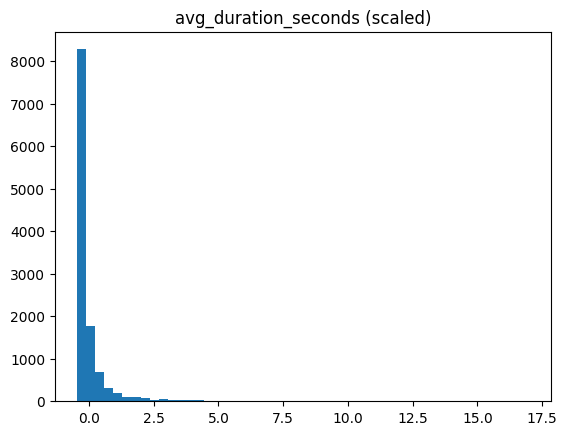

In [38]:
col = train_df_pp[:, 1]

print(f"min: {col.min():.4f}")
print(f"max: {col.max():.4f}")
print(f"mean: {col.mean():.4f}")
print(f"std: {col.std():.4f}")

plt.hist(col, bins=50)
plt.title("avg_duration_seconds (scaled)")
plt.show()

In [42]:
train_df_pp

array([[-1.85472719, -0.44225603,  0.03466269, ..., -0.00604248,
         0.00793457, -0.02038574],
       [ 0.24103244, -0.24540671, -0.20352839, ..., -0.03393555,
         0.01818848, -0.01300049],
       [-0.15349669, -0.15096659, -0.14029301, ...,  0.00196838,
        -0.02563477, -0.01483154],
       ...,
       [ 0.02013317, -0.37599384, -0.2487657 , ...,  0.00540161,
         0.02929688, -0.05932617],
       [ 0.55831922, -0.22400909, -0.22615047, ...,  0.0030365 ,
         0.01330566,  0.0133667 ],
       [ 0.17179525,  0.41237203, -0.2441833 , ..., -0.00765991,
        -0.03051758, -0.02331543]], shape=(11807, 2506))

In [45]:
pca = PCA()
pca.fit(train_df_pp)

PCA()

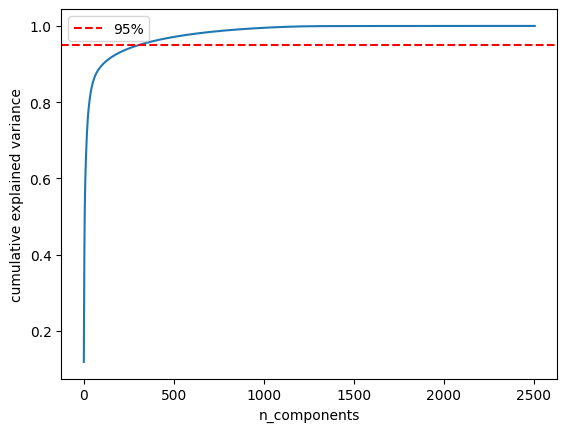

components needed for 95% variance: 308


In [46]:
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumvar)
plt.axhline(0.95, color='r', linestyle='--', label='95%')
plt.xlabel("n_components")
plt.ylabel("cumulative explained variance")
plt.legend()
plt.show()

# find the elbow
n = np.argmax(cumvar >= 0.95) + 1
print(f"components needed for 95% variance: {n}")

In [58]:
pca_real = PCA(n_components=308)
train_df_pca = pca_real.fit_transform(train_df_pp)

In [ ]:
nn_pca = NearestNeighbors(n_neighbors=10, metric="cosine")
nn_pca.fit(train_df_pca)

def get_channel_recs_pca(ch):
    distances, indices = nn_pca.kneighbors(ch)

    recs = df.iloc[indices[0]][["channel_name", "channel_id"]]
    recs["distance"] = distances[0]
    return recs


In [64]:
for i in range(11):
    new_channel = test_df.iloc[[i]]
    print(f"{i} {new_channel["channel_name"]}")

    new_channel_pp = fitted_ct.transform(new_channel)
    new_channel_pca = pca_real.transform(new_channel_pp)
    
    print(get_channel_recs_pca(new_channel_pca))
    print("=============================")
    print("=============================")
    print("=============================\n")

0 304    Blippi - Educational Videos for Kids
Name: channel_name, dtype: object
                 channel_name                channel_id  distance
562                     Morgz  UCBwSufNse8VMBvQM_rCSvgQ  0.073278
7646             Naty TubeFun  UC0vw9w8lyZLgx222zM3zvwA  0.111201
3362      ACC Digital Network  UC0hy7TcR1gGD8nQBqrF2FaA  0.114623
7734           Miko Worldwide  UC6tE97BDG3fW5ZYkblazPsw  0.123540
3220            Binge Central  UCSu7x-J8ESHojsq8mCvFOZw  0.128030
530       Kurt Hugo Schneider  UCplkk3J5wrEl0TNrthHjq4Q  0.128329
1600                  Kaumudy  UCSVALYUGVruJ4I2RjhiudSQ  0.132821
5138  Pocoyo - Nursery Rhymes  UCEzJkg_EtsuPwDnez851ZKw  0.133511
922                FutureVEVO  UCFNosi99Sp0_eLilBiXmmXA  0.150464
1686   Active Self Protection  UCsE_m2z1NrvF2ImeNWh84mw  0.154584

1 14756    RS 1313 SHORT STORIES
Name: channel_name, dtype: object
                                 channel_name                channel_id  \
8899                        Cleetus McFarland  UCh8

In [65]:
pca_real = PCA(n_components=20)
train_df_pca = pca_real.fit_transform(train_df_pp)

nn_pca = NearestNeighbors(n_neighbors=10, metric="cosine")
nn_pca.fit(train_df_pca)

def get_channel_recs_pca(ch):
    distances, indices = nn_pca.kneighbors(ch)

    recs = df.iloc[indices[0]][["channel_name", "channel_id"]]
    recs["distance"] = distances[0]
    return recs

for i in range(11):
    new_channel = test_df.iloc[[i]]
    print(f"{i} {new_channel["channel_name"]}")

    new_channel_pp = fitted_ct.transform(new_channel)
    new_channel_pca = pca_real.transform(new_channel_pp)
    
    print(get_channel_recs_pca(new_channel_pca))
    print("=============================")
    print("=============================")
    print("=============================\n")

0 304    Blippi - Educational Videos for Kids
Name: channel_name, dtype: object
                         channel_name                channel_id  distance
7646                     Naty TubeFun  UC0vw9w8lyZLgx222zM3zvwA  0.002534
10338                 h3h3Productions  UCDWIvJwLJsE4LG1Atne2blQ  0.015665
3362              ACC Digital Network  UC0hy7TcR1gGD8nQBqrF2FaA  0.016014
1600                          Kaumudy  UCSVALYUGVruJ4I2RjhiudSQ  0.019068
7734                   Miko Worldwide  UC6tE97BDG3fW5ZYkblazPsw  0.019139
5138          Pocoyo - Nursery Rhymes  UCEzJkg_EtsuPwDnez851ZKw  0.023060
562                             Morgz  UCBwSufNse8VMBvQM_rCSvgQ  0.023266
1272                          SeseGel  UCazpvRS7wM8k1ItMd-EgCKw  0.023810
8535   Filmakademie Baden-Württemberg  UCSLNwqRKhqIB4WivGwo4pyw  0.028785
8221                      Dave Movies  UC5QnauD9XlIF9Dw89aQ7OKg  0.032363

1 14756    RS 1313 SHORT STORIES
Name: channel_name, dtype: object
                                 chann

In [66]:
pca_real = PCA(n_components=5)
train_df_pca = pca_real.fit_transform(train_df_pp)

nn_pca = NearestNeighbors(n_neighbors=10, metric="cosine")
nn_pca.fit(train_df_pca)

def get_channel_recs_pca(ch):
    distances, indices = nn_pca.kneighbors(ch)

    recs = df.iloc[indices[0]][["channel_name", "channel_id"]]
    recs["distance"] = distances[0]
    return recs

for i in range(11):
    new_channel = test_df.iloc[[i]]
    print(f"{i} {new_channel["channel_name"]}")

    new_channel_pp = fitted_ct.transform(new_channel)
    new_channel_pca = pca_real.transform(new_channel_pp)
    
    print(get_channel_recs_pca(new_channel_pca))
    print("=============================")
    print("=============================")
    print("=============================\n")

0 304    Blippi - Educational Videos for Kids
Name: channel_name, dtype: object
                         channel_name                channel_id  distance
7646                     Naty TubeFun  UC0vw9w8lyZLgx222zM3zvwA  0.004586
2764            Ashish Music Official  UCG58Fm4tNS55opMzzn_tgOA  0.005048
4950                           Marszz  UCYTP0bC967TUg2WMlX6_vzw  0.005363
6548                  State of Israel  UCt6Fq64J2rTswe4uhZtxNtg  0.006591
2820               MagicSoundOfficial  UCE27sA-j6Prv4kpuqv2Js-Q  0.008964
2466                             SHAY  UCSCfAQztifsotBpwa-CbOvQ  0.009337
5428   Super Simple Play with Caitie!  UCxG6Tbopv4XcHfem65bgFeg  0.009706
11310                        itsRucka  UC-B2LyEZcl3avG0coKeohGQ  0.012383
3048                     MD JCB XPERT  UC0S4TBEsQgiyMJaZ5z1w_Mw  0.012891
7205                   MovieboxMovies  UC8Artr_jqToYkRKjgjhezmw  0.013108

1 14756    RS 1313 SHORT STORIES
Name: channel_name, dtype: object
                     channel_name     